## UMAP Variance Explained

#### Nikolay Oskolkov, SciLifeLab, NBIS Long Term Support, [nikolay.oskolkov@scilifelab.se](nikolay.oskolkov@scilifelab.se)

<h3><center>Abstract</center></h3>
In this notebook, we will suggest a method of estimating variance explained by UMAP components.

### Table of Contents:
* [Preparing MNIST Data for Analysis](#Preparing-MNIST-Data-for-Analysis)
* [MNIST variation explained by PCA components](#MNIST-variation-explained-by-PCA-components)
* [MNIST variation explained by UMAP components](#MNIST-variation-explained-by-UMAP-components)
* [Biological variation explained by UMAP components](#Biological-variation-explained-by-UMAP-components)

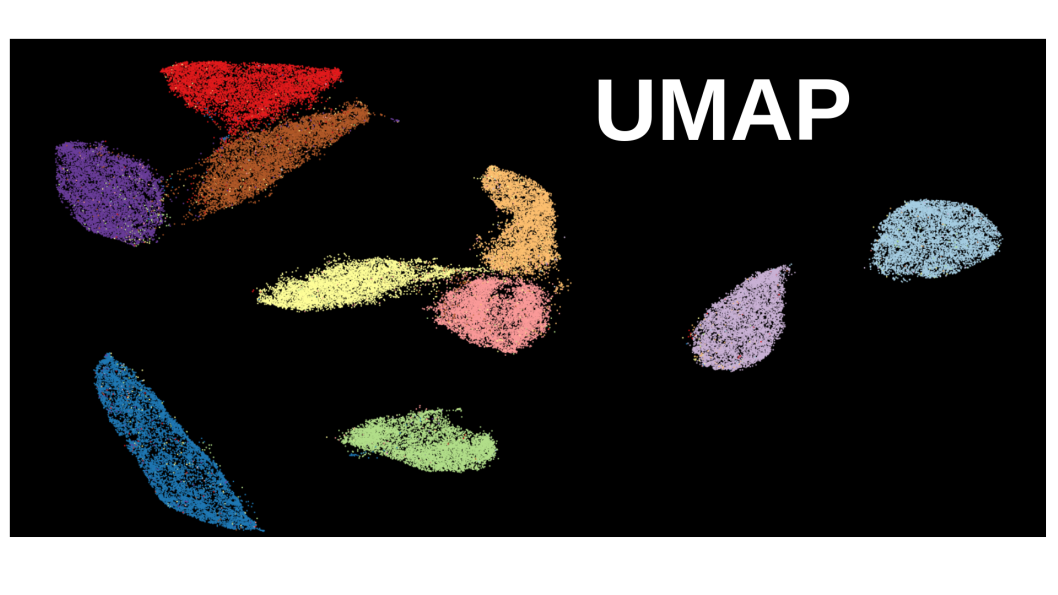

In [1]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/UMAP_VarianceExplained/UMAP.png', width = 2000)

### Preparing MNIST Data for Analysis <a class="anchor" id="Preparing-MNIST-Data-for-Analysis"></a>

As a banchmark dataset we will be using MNIST: 70 000 black-and-white images of hand-written digists of 28 x 28 pixels resolution (784 pixels per image). First, we will download the MNIST dataset, check its dimensions and visualize a few random images.

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
labels = mnist.target.astype(int)
mnist.data.shape

(70000, 784)

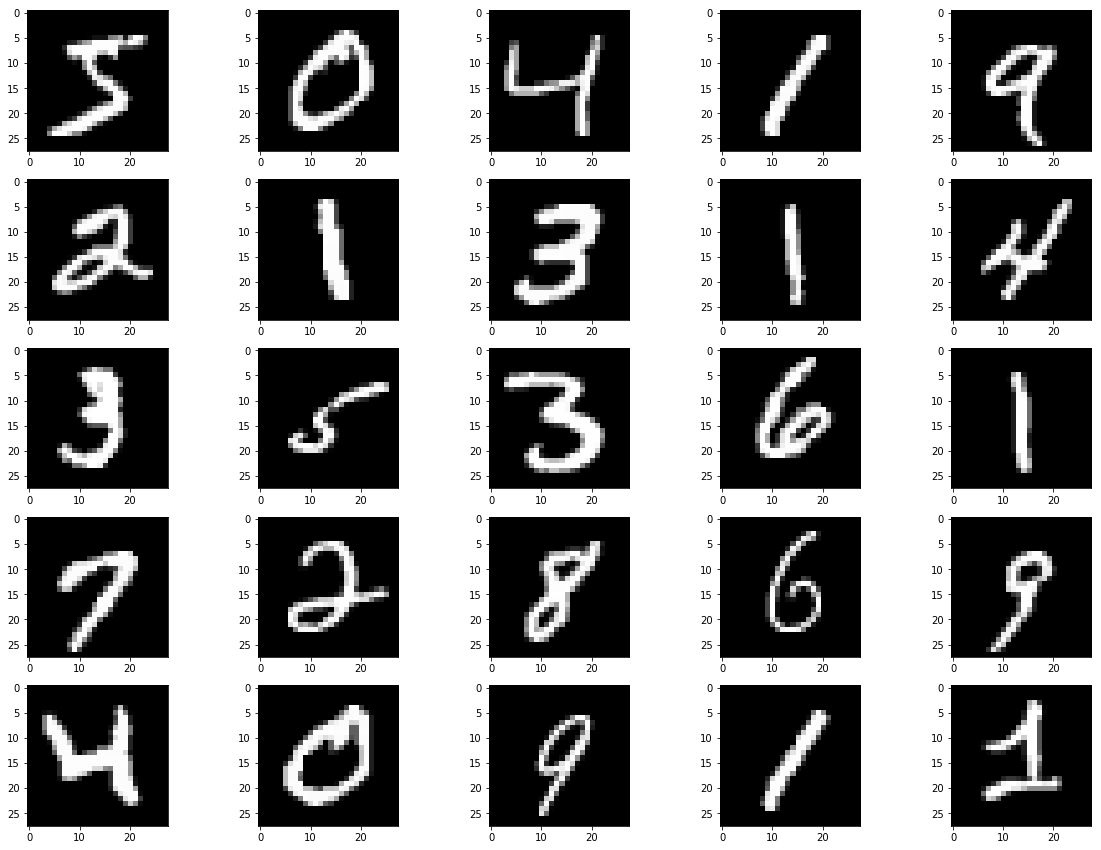

In [3]:
from matplotlib import pyplot as plt

plt.figure(figsize = (20, 15))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(mnist.data[i].reshape(28, 28), cmap = plt.get_cmap('gray'))
plt.show()

The values of MNIST dataset represent pixel intensities varying from 0 to 255, where 0 corresponds to the black background. Therefore, MNIST is a "zero-inflated" dataset which is very similar to a typical single cell gene expression dataset. It is usually recommended to normalize the black-and-white pixel intensities by the largest 255 value. However, here, by analogy with single cell gene expression, we will use a log-transform as another way to normalize a "zero-inflated" dataset.

In [4]:
import numpy as np

N_points = 10000

X = np.log10(mnist.data + 1)
#X = mnist.data / 255

np.random.seed(123)
random_indices = np.random.choice(X.shape[0], size = N_points, replace = False)
X = X[random_indices,:]
labels = labels[random_indices]

X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

As a first exploratory step, in order to understand the variation in the MNIST, we will perform a PCA analysis on the MNIST itself and a shuffled version of MNIST. This will help us to estimate the number of meaningful, i.e. non-redundant, dimensions out of the initial 784 dimensions, i.e. we will figure our the number of **informative dimensions** to keep for all future tested dimension reduction and clustering techniques.

Observed variance explained:
[0.11043074 0.07698788 0.06564009 0.05835455 0.04983201 0.04556471
 0.03336833 0.02898735 0.02736869 0.02373547]


Finished 1 permutations
Finished 2 permutations
Finished 3 permutations
Finished 4 permutations
Finished 5 permutations
Finished 6 permutations
Finished 7 permutations
Finished 8 permutations
Finished 9 permutations
Finished 10 permutations

Permuted variance explained:
[0.0021104952237763594, 0.0020828173531311058, 0.0020737835173461686, 0.00206818153707653, 0.0020594072690765706, 0.002054177395672734, 0.002044391263394533, 0.002040223352944923, 0.0020368949440908233, 0.0020312493727298563]

Number of significant Principal Components: 62
Together they explain 86% of variation in the data


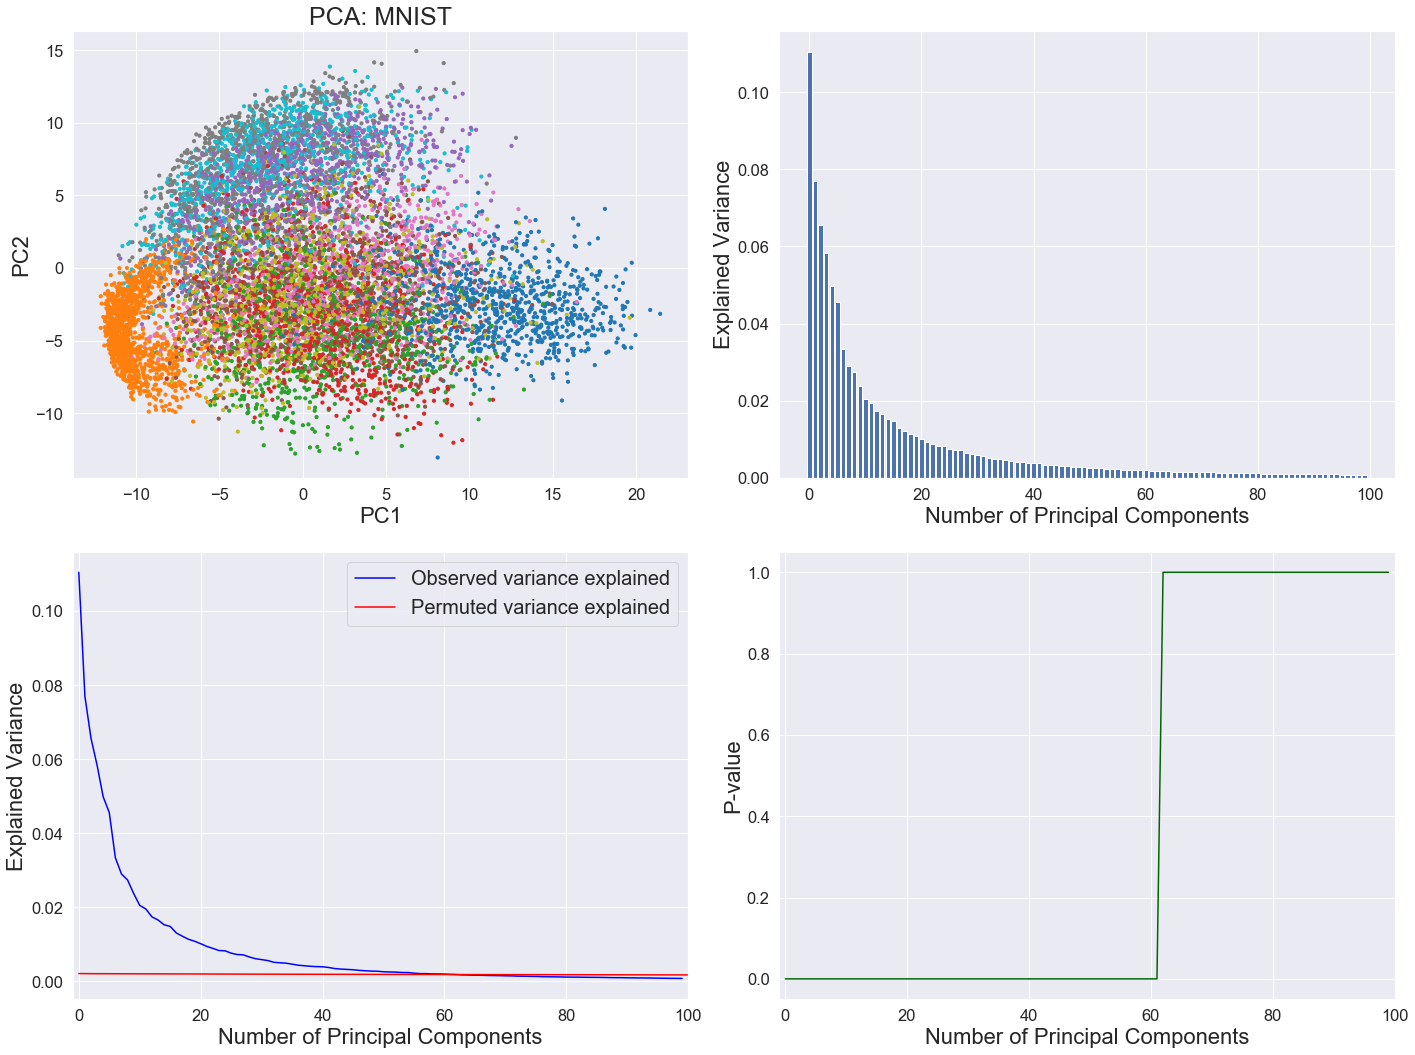

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import seaborn as sns
sns.set(font_scale = 1.5)

N_pca_comps = 100

figure = plt.figure(figsize = (20, 15))

plt.subplot(221)
X_reduced = PCA(n_components = 2).fit_transform(X)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c = labels, cmap = 'tab10', s = 10)
plt.title('PCA: MNIST', fontsize = 25)
plt.xlabel('PC1', fontsize = 22); plt.ylabel('PC2', fontsize = 22)

plt.subplot(222)
pca = PCA(n_components = N_pca_comps).fit(X)
print('Observed variance explained:')
print(pca.explained_variance_ratio_[0:10])
print('\n')
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel('Number of Principal Components', fontsize = 22)
plt.ylabel('Explained Variance', fontsize = 22)

N_perm = 10
X_flat = X.flatten()
expl_var_perm_df = pd.DataFrame(index = list(range(N_perm)), columns = list(range(X.shape[1])))
for i in range(N_perm):
    np.random.shuffle(X_flat)
    X_perm = X_flat.reshape(X.shape[0], X.shape[1])
    pca_perm = PCA().fit(X_perm)
    expl_var_perm_df.loc[i] = pca_perm.explained_variance_ratio_
    print('Finished {} permutations'.format(i + 1))
    X_perm = list(expl_var_perm_df.mean(axis = 0) + 2*expl_var_perm_df.std(axis = 0)) 

print('\nPermuted variance explained:')
print(X_perm[0:10])

plt.subplot(223)
plt.plot(pca.explained_variance_ratio_, c = 'blue')
plt.plot(X_perm, c = 'red')
plt.xlim([-1, N_pca_comps])
plt.xlabel('Number of Principal Components', fontsize = 22)
plt.ylabel('Explained Variance', fontsize = 22)
plt.gca().legend(('Observed variance explained', 'Permuted variance explained'), fontsize = 20)

plt.subplot(224)
pval = list()
for j in range(N_pca_comps):
    pval.append(np.sum(expl_var_perm_df.iloc[:, j] + 2*expl_var_perm_df.std(axis = 0) >= 
                       pca.explained_variance_ratio_[j]) / N_perm)
plt.plot(pval, c = 'darkgreen')
plt.xlabel('Number of Principal Components', fontsize = 22)
plt.ylabel('P-value', fontsize = 22)
plt.xlim([-1, N_pca_comps])
N_opt_pcs = np.where(np.array(pval) >= 0.05)[0][0]
print('\nNumber of significant Principal Components: {}'.format(N_opt_pcs))
print('Together they explain {}% of variation in the data'.
      format(int(round(sum(pca.explained_variance_ratio_[0:np.where(np.array(pval) >= 0.05)[0][0]])*100,0))))

figure.tight_layout()

plt.show()

An important outcome of the PCA analysis on MNIST and shuffled MNIST is that the dataset seems to have **71 informative principal components that all together capture ~90% of variation in the data**. Therefore, if we replace the original data with 784 features with 71 PCs, we will keep most of the variation in the data but will reduce dimensionality of the data by ~10 times.

Now let us visualize the MNIST dataset in 2D using UMAP and tSNE dimension reduction techniques. In both cases we will use 2 principal components from the PCA analysis for initialization. Perplexity for tSNE and the number of nearest neighbors for UMAP will be computed as a squere root of the number of data points (images).

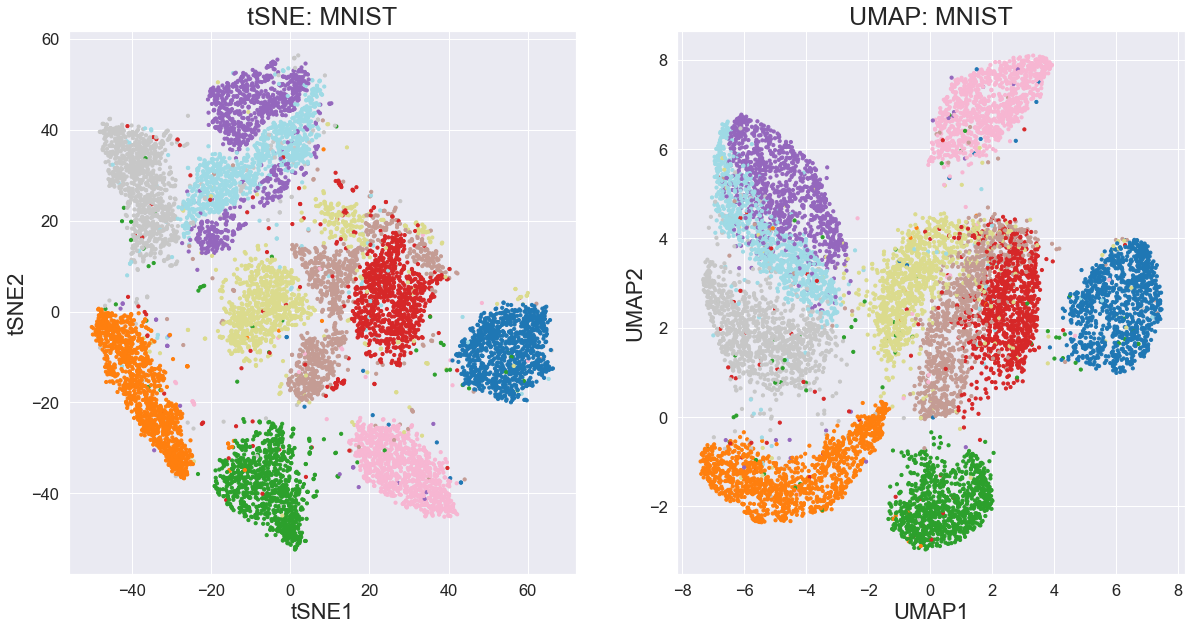

CPU times: user 7min 20s, sys: 3.5 s, total: 7min 24s
Wall time: 3min 26s


In [6]:
%%time

import warnings
warnings.filterwarnings('ignore')

import umap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

opt_perp = np.int(np.round(np.sqrt(X.shape[0]), 0))
X_reduced = PCA(n_components = N_opt_pcs).fit_transform(X)

umap_embedding = umap.UMAP(n_components = 2, n_neighbors = opt_perp, init = X_reduced[:, 0:2], 
                           min_dist = 0.3, n_epochs = 1000, random_state = 123, 
                           verbose = 0).fit_transform(X_reduced)

tsne_embedding = TSNE(n_components = 2, perplexity = opt_perp, init = X_reduced[:, 0:2], 
                      learning_rate = 200, n_iter = 1000, random_state = 123, 
                      verbose = 0).fit_transform(X_reduced)

sns.set(font_scale = 1.5)
plt.figure(figsize = (20, 10))

plt.subplot(121)
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c = labels, s = 10, cmap = 'tab20')
plt.title('tSNE: MNIST', fontsize = 25)
plt.xlabel("tSNE1", fontsize = 22); plt.ylabel("tSNE2", fontsize = 22)

plt.subplot(122)
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c = labels, s = 10, cmap = 'tab20')
plt.title('UMAP: MNIST', fontsize = 25)
plt.xlabel("UMAP1", fontsize = 22); plt.ylabel("UMAP2", fontsize = 22)

plt.show()

One very simple and well known conclusion that can be drawn from the comparison of 2D PCA, tSNE and UMAP pictures is that the classes of hand-written digits are much more resolved by non-linear neighbor-graph based dimension reduction techniques such as tSNE and UMAP compared to the linear matrix factorization techniques such as PCA. Therefore, if we assume that the classes of hand-written digits (aka biological phenotype, e.g. cell type in scRNAseq experiments) comprise most of the variation in the MNIST data, it makes sense to hypothesize that **the two tSNE and UMAP components are capabale of capturing more biological variation than the two PCA components**. In the next sections, we will try to quantify and prove this hypothesis. 

### MNIST variation explained by PCA components <a class="anchor" id="MNIST-variation-explained-by-PCA-components"></a>

As a non-linear neighbor-graph based technique, UMAP does not seem to have a concept of variance explained by its components in contrast to the matrix factorization linear dimension reduction techniques such as PCA, see for example the [answer](https://github.com/lmcinnes/umap/issues/122) of Leland McInnes, the creator of UMAP. 

Nevertheless, we will try to quantify the amount of MNIST variation explained by UMAP components, and compare it with the amount of variation explained by PCA components using **Partial Least Square (PLS) regression** and the [**R-squared statistic**](https://en.wikipedia.org/wiki/Coefficient_of_determination) extended for matrix operations. Let us check how exactly we compute the total "variation" (or variance in mathematical terminology) explained by all principal components, we can easily compute and extract it from PCA as the sum of all eigen values of MNIST.

In [6]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components = X.shape[1]).fit(X)
pca_comps = PCA().fit_transform(X)

sum(pca.explained_variance_)

374.66907222673694

Next, by definition, variance is given by the following equation in the matrix form (and then translation to non-matrix, i.e. vector, form):

$$
||\boldsymbol{X}||^2=\frac{1}{N-1}(\boldsymbol{X}-\boldsymbol{\bar{X}})^2
$$

$$
\rm{Var}(x)=\frac{1}{N-1}\sum_{i=1}^N(x_i-\bar{x})^2
$$

where $N$ is the number of statistical observations (number of images for MNIST), and $\boldsymbol{\bar{X}}$ is the mean intensity for each of 784 pixels across the $N$ images for MNIST. Let us check whether using this definition we can reproduce the variance above computed by PCA.

In [7]:
np.sum((X - np.mean(X, axis = 0))**2) / (X.shape[0] - 1)

374.6690722267373

We can nicely reproduce the total variance in MNIST computed by PCA above. What we essentially do here, we compute a vector-row with 784 elements, each of them corresponds to one pixel, and the value of the element is the average intensity of the pixel across all images. Next, for each image (a \[1 x 784\] vector) we subtract this vector of average pixel intensities, make the difference squared, and sum up across all images and all pixels. This will give us how intensity of each pixel in each image is different from an average pixel intensity across all images. In other words, it tells us **how different each image from an "average image"**.

Now, once we have learnt how to compute the total variance from scratch, let us learn how to compute the fraction of the total variance explained the first principal component. For this purpose, we will display this fraction from the PCA algorithm which is the first eigen value normalized by the total sum of all 784 eigen values.

In [8]:
pca.explained_variance_ratio_[0]

0.11043073983593521

In [9]:
pca.explained_variance_[0] / np.sum(pca.explained_variance_)

0.11043073983593521

Now, we will reproduce this number from the **Partial Least Squares (PLS)** regression. We will use the following logic. Suppose we want to approximate a matrix **X** by another matrix **PCA_matrix**, which for now includes only one column (first principal component) but for MNIST data set can generally include up to 784 columns. Then, we can fit a linear regression model of **X = B \* PCA_matrix** and compute an R-squared statistic which will reflect the amount of variation in **X** explained by **PCA_matrix**. In the matrix form, the [R-squared statistic](https://en.wikipedia.org/wiki/Coefficient_of_determination) will be given by the following equation:

$$\boldsymbol{R^2}=1-\frac{||\boldsymbol{X}-\boldsymbol{B*PCA_{matrix}}||^2}{||\boldsymbol{X}||^2}$$

where **B \* PCA_matrix** represents a prediction of matrix **X** from its approximation **PCA_matrix** and will be found from the PLS regression. To technically implement this procedure in scikit-learn Python module, we will first fit a PLS model with **X** as a response variable and **PCA_matrix** as explanatory variable, then compute a prediction **y_pred = B \* PCA_matrix**, and then we can either use the **r2_score** function in scikit-learn or the equation above for computing the [R-squared statistic](https://en.wikipedia.org/wiki/Coefficient_of_determination). Let us check that both will give identical answers:

In [10]:
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

PCA_matrix = pd.DataFrame(pca_comps[:, 0:1])
pls = PLSRegression(n_components = 1)

pls.fit(PCA_matrix, X)
y_pred = pls.predict(PCA_matrix)

r2_score(X, y_pred, multioutput = 'variance_weighted')

0.11043073983593246

In [11]:
1 - np.sum((np.array(X) - np.array(y_pred))**2) / np.sum((X - np.mean(X, axis = 0))**2)

0.11043073983593554

In this way, by using PLS, we computed the fraction of total MNIST variation explained by the first principal component outside of the PCA algorithm. Please compare this fraction calculated by PLS with the variance explained reported by the PCA algorithm above (as a ratio of first eigen value divided by the sum of all eigen values), they are nearly identical. Now let **PCA_matrix** consist of a number of principal components. Below we demonstrate that the PLS computation of cummulative fraction of variance explained by principal components will result in nearly identical to PCA cummulative variance explained.

In [12]:
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

predicted_var_expl = []
for i in range(1, 21):
    
    PCA_matrix_current = pd.DataFrame(pca_comps[:, 0:i])
    pls_current = PLSRegression(n_components = i)
    pls_current.fit(PCA_matrix_current, X)
    y_pred_current = pls_current.predict(PCA_matrix_current)
    predicted_var_expl.append(r2_score(X, y_pred_current, multioutput = 'variance_weighted'))
    
np.array(predicted_var_expl)

array([0.11043074, 0.18741862, 0.2530587 , 0.31141325, 0.36124526,
       0.40680998, 0.44017831, 0.46916566, 0.49653434, 0.52026981,
       0.54076974, 0.56031203, 0.5777234 , 0.59429863, 0.60957   ,
       0.62440418, 0.63747187, 0.64965247, 0.66101228, 0.67184558])

In [13]:
np.cumsum(pca.explained_variance_ratio_[0:20])

array([0.11043074, 0.18741862, 0.2530587 , 0.31141325, 0.36124526,
       0.40680998, 0.44017831, 0.46916566, 0.49653434, 0.52026981,
       0.54076974, 0.56031203, 0.5777234 , 0.59429863, 0.60957   ,
       0.62440418, 0.63747187, 0.64965247, 0.66101228, 0.67184558])

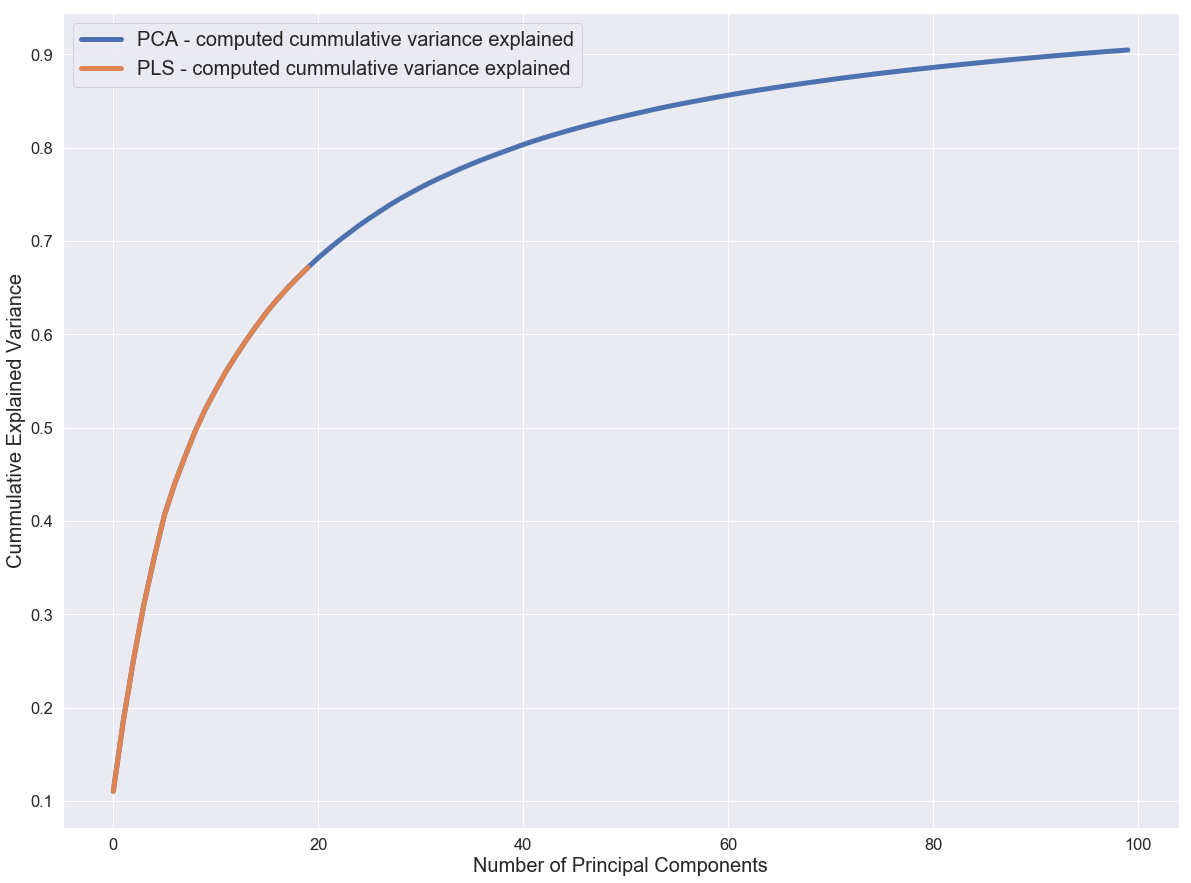

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

plt.figure(figsize = (20, 15))

plt.plot(np.cumsum(pca.explained_variance_ratio_[0:100]), linewidth = 5)
plt.plot(predicted_var_expl, linewidth = 5)

plt.ylabel('Cummulative Explained Variance', fontsize = 20)
plt.xlabel('Number of Principal Components', fontsize = 20)
plt.legend(['PCA - computed cummulative variance explained', 
            'PLS - computed cummulative variance explained'], fontsize = 20)

plt.show()

We can see that the curves of cummulative variance explained computed by PLS and PCA **nicely coincide**. This is no surpise since the PLS computation essentially mimics what is going under the hood in the PCA algorithm. However, very importantly, this gives us an **instrument** of computing variance of **X** explained by **any approximation**, i.e. not only the PCA matrix. In the next session, we will use **UMAP_matrix** as an approximation of the original **X** matrix of MNIST pixel intensities and compare the cummulative variance of **X** explained by UMAP and PCA components.

### MNIST variation explained by UMAP components <a class="anchor" id="MNIST-variation-explained-by-UMAP-components"></a>

In this section, we will use the methodology of PLS estimation of variance explained developed in the previous section. We will use the following reasoning. Since UMAP gives some sort of **approximation** of the original data **X**, and people even run clustering on 2D UMAP for discovering cell types in scRNAseq field, we can use the **UMAP_matrix** (and we can do the same for tSNE) as an approximation of **X**, fit the PLS model **X = B \* UMAP_matrix**, and estimate the fraction of MNIST variance explained by UMAP  components as

$$\boldsymbol{R^2}=1-\frac{||\boldsymbol{X}-\boldsymbol{B*UMAP_{matrix}}||^2}{||\boldsymbol{X}||^2}$$


Since we would like to use **multiple** tSNE and UMAP components as an approximation for the original data set **X**, let us now fit UMAP and tSNE for more than two components. It is relateively straightforward to do for UMAP.

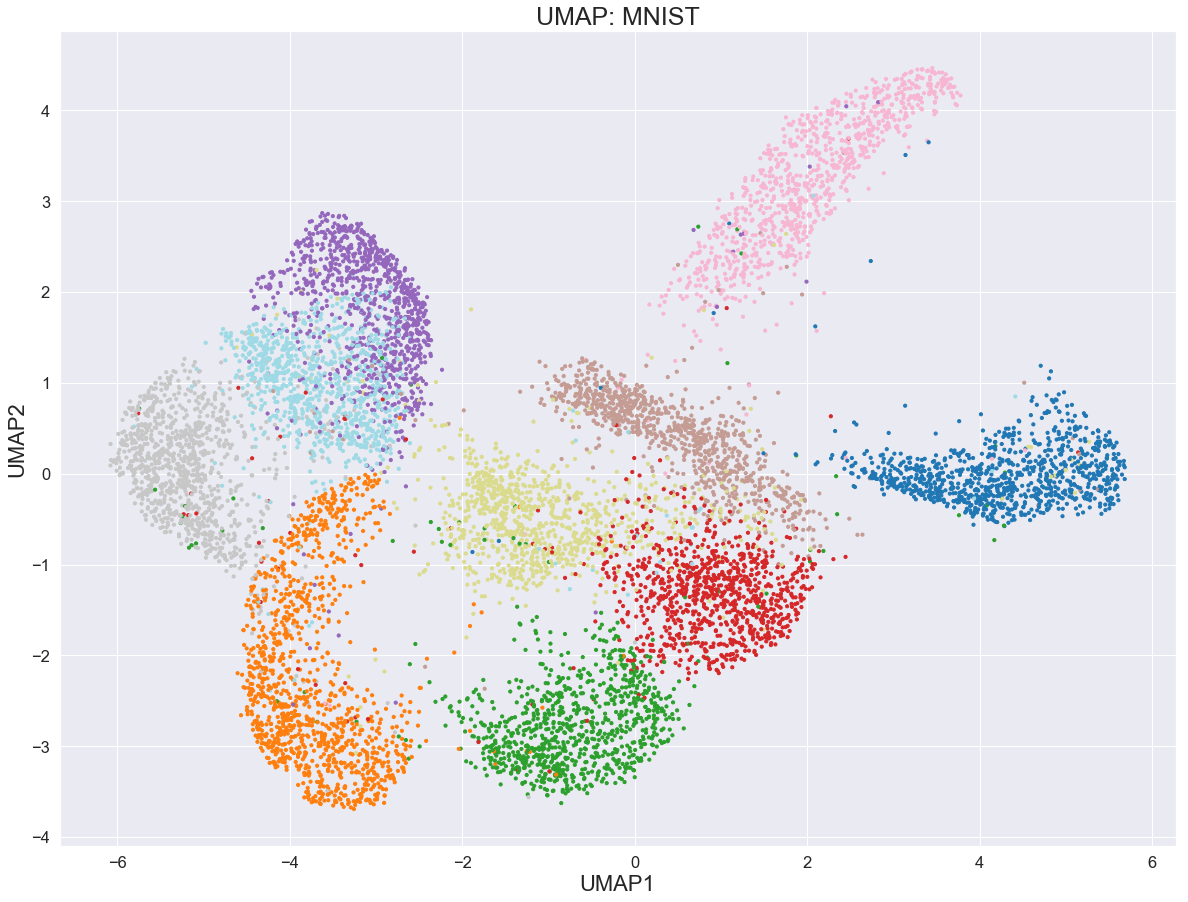

CPU times: user 2min 21s, sys: 3.16 s, total: 2min 24s
Wall time: 2min 7s


In [15]:
%%time

import warnings
warnings.filterwarnings('ignore')

import umap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

opt_perp = np.int(np.round(np.sqrt(X.shape[0]), 0))
X_reduced = PCA(n_components = N_opt_pcs).fit_transform(X)


N_comps = 3
umap_embedding = umap.UMAP(n_components = N_comps, n_neighbors = opt_perp, init = X_reduced[:, 0:N_comps], 
                           min_dist = 0.3, n_epochs = 1000, random_state = 123, 
                           verbose = 0).fit_transform(X_reduced)

sns.set(font_scale = 1.5)
plt.figure(figsize = (20, 15))

plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c = labels, s = 10, cmap = 'tab20')
plt.title('UMAP: MNIST', fontsize = 25)
plt.xlabel("UMAP1", fontsize = 22); plt.ylabel("UMAP2", fontsize = 22)

plt.show()

Please note in the picture above that the **quality of the UMAP 2D representation degraded** a lot when we tried to fit the UMAP model on MNIST data for more than two components. Why this happens is unclear so far. perhaps there are problems with convergence, however increasing the number of epoches does not seem to fix this loss in quality, to my experience. To compute multiple tSNE components is difficult **computationally**. The default tSNE algorithm used by scikitlearn for computing 2-3 components is Barnes-Hut which is quite fast. However, for computing more that 2-3 components one will have to use **method = 'exact'** which is very slow and might take many hours and even days for large data sets.

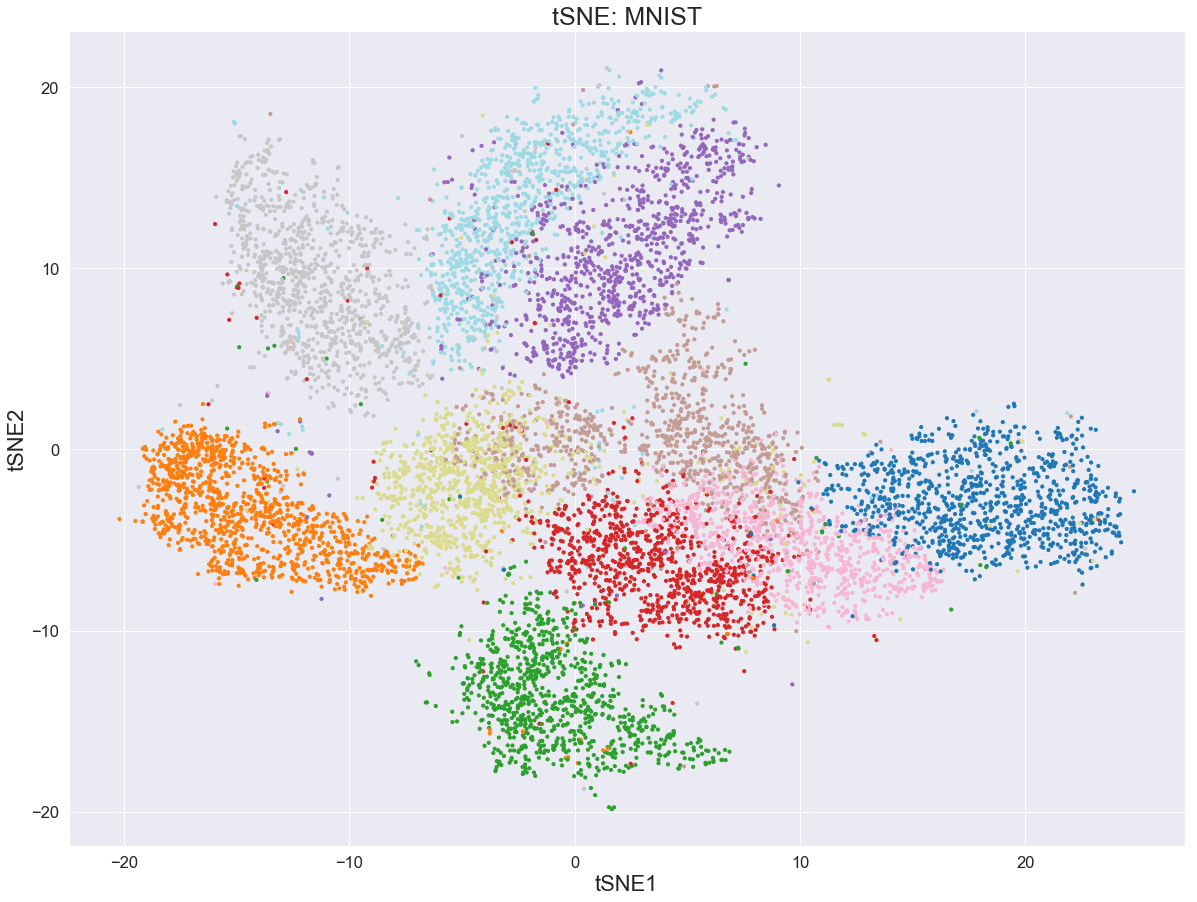

CPU times: user 20min 10s, sys: 2.76 s, total: 20min 12s
Wall time: 5min 20s


In [16]:
%%time

import warnings
warnings.filterwarnings('ignore')

import umap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

opt_perp = np.int(np.round(np.sqrt(X.shape[0]), 0))
X_reduced = PCA(n_components = N_opt_pcs).fit_transform(X)


N_comps = 3
tsne_embedding = TSNE(n_components = N_comps, perplexity = opt_perp, init = X_reduced[:, 0:N_comps], 
                      learning_rate = 200, n_iter = 1000, random_state = 123, 
                      verbose = 0).fit_transform(X_reduced)

#tsne_embedding = TSNE(n_components = N_comps, perplexity = opt_perp, init = X_reduced[:, 0:N_comps], 
#                      learning_rate = 200, n_iter = 1000, random_state = 123, 
#                      verbose = 0, method = 'exact').fit_transform(X_reduced)

sns.set(font_scale = 1.5)
plt.figure(figsize = (20, 15))

plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c = labels, s = 10, cmap = 'tab20')
plt.title('tSNE: MNIST', fontsize = 25)
plt.xlabel("tSNE1", fontsize = 22); plt.ylabel("tSNE2", fontsize = 22)

plt.show()

Now let us use the PLS methodology developed in the previous sections, and compute the fraction of MNIST variance explained by the first UMAP component.

In [17]:
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

UMAP_matrix = pd.DataFrame(umap_embedding[:, 0:1])

pls = PLSRegression(n_components = 1)
pls.fit(UMAP_matrix, X)
y_pred = pls.predict(UMAP_matrix)

r2_score(X, y_pred, multioutput = 'variance_weighted')

0.07335034485651613

In [18]:
1 - np.sum((np.array(X) - np.array(y_pred))**2) / np.sum((X - np.mean(X, axis = 0))**2)

0.07335034485652026

And here we compute how much of MNIST variance is explained by the first tSNE component.

In [19]:
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

tSNE_matrix = pd.DataFrame(tsne_embedding[:, 0:1])

pls = PLSRegression(n_components = 1)
pls.fit(tSNE_matrix, X)
y_pred = pls.predict(tSNE_matrix)

r2_score(X, y_pred, multioutput = 'variance_weighted')

0.07265918428990921

In [20]:
1 - np.sum((np.array(X) - np.array(y_pred))**2) / np.sum((X - np.mean(X, axis = 0))**2)

0.07265918428991347

We conclude that both **UMAP and tSNE first components explain about ~7% of MNIST variation which is lower than the 11% explained by the first PCA component**. This is not surprising. Intuitively, it is hard to expect that there can be another latent variable alternative to PC1 that explains more than 11% of MNIST variation without redefining the concept of "explained variance". The current definition comes from the PCA (normalized eigen values) and linear regression (R-squared) analyses. Both are linear frameworks. Moreover, PC1 by definition corresponds to a direction of maximum variation in MNIST. Therefore, if a latent variable comes from a nonlinear analysis, such as UMAP, that does not *per se* attemts to maximize variation in the data, it would be hard to expect that e.g. a UMAP1 explains more variation in MNIST **within linear definition of "variance explained"**. Now we will calculate the variance explained by a few top tSNE and UMAP components.

In [90]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

N_iter = 3
N_comps = 3

N_points_list = [5000, 10000, 15000]
predicted_var_expl_matrix = np.zeros(shape = (N_iter, N_comps))
for j in range(N_iter):
    
    X = np.log10(mnist.data + 1)
    labels = mnist.target.astype(int)
    
    np.random.seed(j)
    random_indices = np.random.choice(X.shape[0], size = N_points_list[j], replace = False)
    X_sample = X[random_indices,:]
    labels_sample = labels[random_indices]

    pca_comps_sample = PCA(n_components = N_comps).fit_transform(X_sample)

    predicted_var_expl = []
    for i in range(1, (N_comps + 1)):
    
        PCA_matrix_current = pd.DataFrame(pca_comps_sample[:, 0:i])
        pls_current = PLSRegression(n_components = i)
        pls_current.fit(PCA_matrix_current, X_sample)
        y_pred_current = pls_current.predict(PCA_matrix_current)
        predicted_var_expl.append(r2_score(X_sample, y_pred_current, multioutput = 'variance_weighted'))
    
    predicted_var_expl_matrix[j,:] = predicted_var_expl
    
print(predicted_var_expl_matrix)

[[0.10780598 0.18642903 0.25086806]
 [0.10939031 0.18671329 0.25279746]
 [0.10868969 0.18615405 0.25226694]]


In [91]:
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

N_iter = 3
N_comps = 3

min_dist_list = [0.1, 0.2, 0.3]
predicted_var_expl_umap_matrix = np.zeros(shape = (N_iter, N_comps))
for j in range(N_iter):
    
    X = np.log10(mnist.data + 1)
    labels = mnist.target.astype(int)
    
    np.random.seed(j)
    random_indices = np.random.choice(X.shape[0], size = N_points, replace = False)
    X_sample = X[random_indices,:]
    labels_sample = labels[random_indices]

    opt_perp = np.int(np.round(np.sqrt(X_sample.shape[0]), 0))
    X_reduced_sample = PCA(n_components = N_opt_pcs).fit_transform(X_sample)
    umap_embedding_sample = umap.UMAP(n_components = N_comps, n_neighbors = opt_perp, 
                                      init = X_reduced_sample[:, 0:N_comps], min_dist = min_dist_list[j], 
                                      n_epochs = 1000, verbose = 0).fit_transform(X_reduced_sample)

    predicted_var_expl_umap = []
    for i in range(1, (N_comps + 1)):
    
        UMAP_matrix_current = pd.DataFrame(umap_embedding_sample[:, 0:i])
        pls_current = PLSRegression(n_components = i)
        pls_current.fit(UMAP_matrix_current, X_sample)
        y_pred_current = pls_current.predict(UMAP_matrix_current)
        predicted_var_expl_umap.append(r2_score(X_sample, y_pred_current, multioutput = 'variance_weighted'))
    
    predicted_var_expl_umap_matrix[j,:] = predicted_var_expl_umap
    
print(predicted_var_expl_umap_matrix)

[[0.07196995 0.11128765 0.15727548]
 [0.07368611 0.11553589 0.16574399]
 [0.07368436 0.1146819  0.16384556]]


Above, we tried to **"perturb"** UMAP embeddings and address how **sensitive** they are towards **min_dist** hyperparameter, therefore we used a few different values of **min_dist**. Additionally, we subsampled the total MNIST dataset a few times using different seeds in order to check how robust our conclusions are with respect to resampling. This deliberate "perturbation" of UMAP embeddings allows us to compute confidence intervals of the MNIST variance explained by top UMAP components. Further, below we will compute percentage of MNIST variance explained by top tSNE components while again applying a minor "perturbation" via resampling and varying **perplexity** values.

In [92]:
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

N_iter = 3
N_comps = 3

perp_list = [50, 100, 150]
predicted_var_expl_tsne_matrix = np.zeros(shape = (N_iter, N_comps))
for j in range(N_iter):
    
    X = np.log10(mnist.data + 1)
    labels = mnist.target.astype(int)
    
    np.random.seed(j)
    random_indices = np.random.choice(X.shape[0], size = N_points, replace = False)
    X_sample = X[random_indices,:]
    labels_sample = labels[random_indices]

    X_reduced_sample = PCA(n_components = N_opt_pcs).fit_transform(X_sample)
    tsne_embedding_sample = TSNE(n_components = N_comps, perplexity = perp_list[j], 
                                 init = X_reduced_sample[:, 0:N_comps], learning_rate = 200, n_iter = 1000, 
                                 verbose = 0).fit_transform(X_reduced_sample)

    predicted_var_expl_tsne = []
    for i in range(1, (N_comps + 1)):
    
        tSNE_matrix_current = pd.DataFrame(tsne_embedding_sample[:, 0:i])
        pls_current = PLSRegression(n_components = i)
        pls_current.fit(tSNE_matrix_current, X_sample)
        y_pred_current = pls_current.predict(tSNE_matrix_current)
        predicted_var_expl_tsne.append(r2_score(X_sample, y_pred_current, multioutput = 'variance_weighted'))
    
    predicted_var_expl_tsne_matrix[j,:] = predicted_var_expl_tsne
    
print(predicted_var_expl_tsne_matrix)

[[0.0726033  0.12883257 0.17227594]
 [0.07509911 0.13051282 0.17576426]
 [0.07216336 0.12307453 0.16901676]]


Finally, let us visualize the fractions of MNIST variance explained by leading components of PCA, tSNE and UMAP:

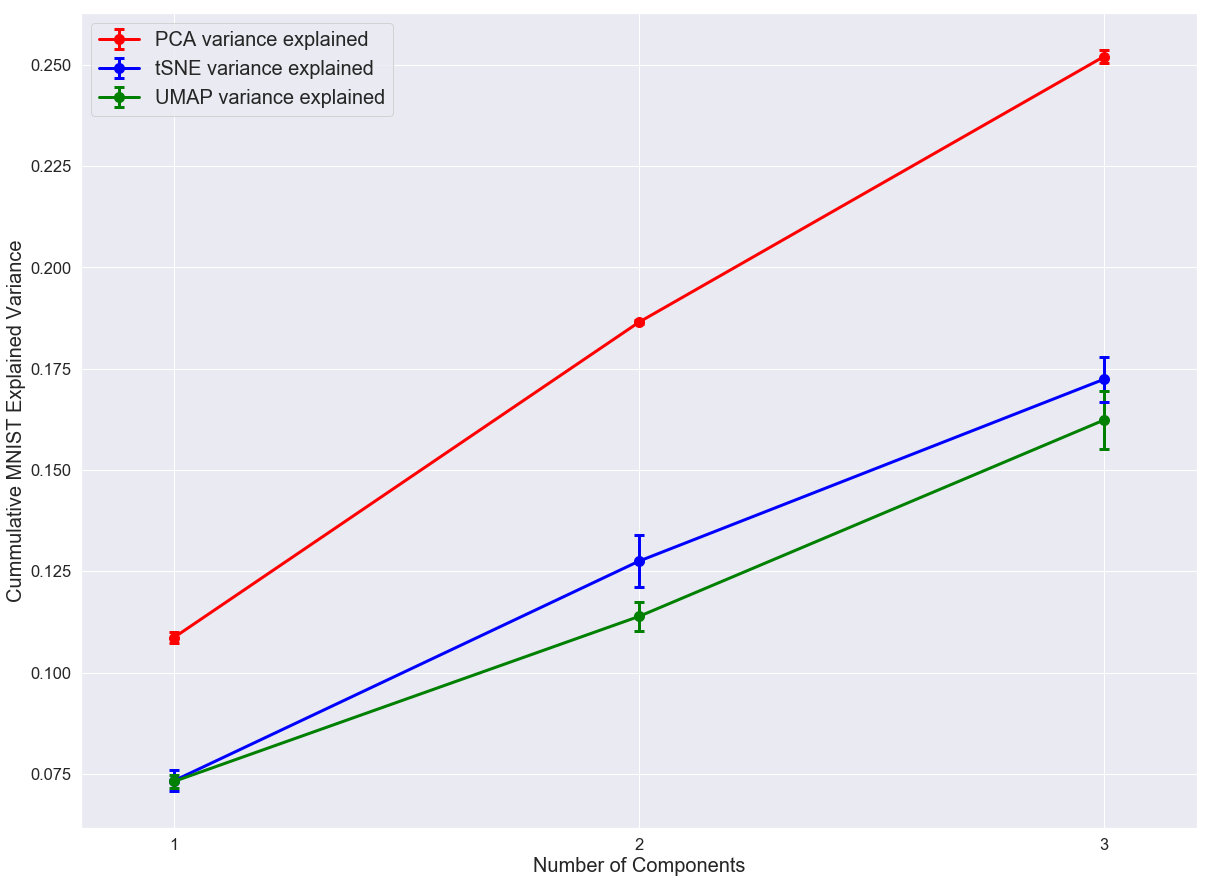

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

plt.figure(figsize = (20, 15))

plt.errorbar(range(1, (N_comps + 1)), np.mean(predicted_var_expl_matrix, axis = 0), 
             yerr = 2*np.std(predicted_var_expl_matrix, axis = 0), linewidth = 3, color = 'red', 
             marker = 'o', markersize = 10, capsize = 5, capthick = 3)
plt.errorbar(range(1, (N_comps + 1)), np.mean(predicted_var_expl_tsne_matrix, axis = 0), 
             yerr = 2*np.std(predicted_var_expl_tsne_matrix, axis = 0), linewidth = 3, color = 'blue', 
             marker = 'o', markersize = 10, capsize = 5, capthick = 3)
plt.errorbar(range(1, (N_comps + 1)), np.mean(predicted_var_expl_umap_matrix, axis = 0), 
             yerr = 2*np.std(predicted_var_expl_umap_matrix, axis = 0), linewidth = 3, color = 'green', 
             marker = 'o', markersize = 10, capsize = 5, capthick = 3)

plt.ylabel('Cummulative MNIST Explained Variance', fontsize = 20)
plt.xlabel('Number of Components', fontsize = 20)
plt.legend(['PCA variance explained', 'tSNE variance explained', 'UMAP variance explained'], fontsize = 20)
plt.xlim([0.8, (N_comps + 0.2)])
plt.xticks([1, 2, 3])

plt.show()

We conclude that leading PCA components explain consistently more variation in MNIST dataset than leading tSNE and UMAP components. This result was expected since UMAP and tSNE do no aim at building directions of maximal variation in contrast to PCA. Further, the amounts of variation in MNIST explained by leading tSNE and UMAP components are comparable and both lower than PCA. Therefore we seem to observe a systematic difference in explained variation between matrix factorization and neghbor-graph based dimension reduction techniques.

### Biological variation explained by UMAP components <a class="anchor" id="Biological-variation-explained-by-UMAP-components"></a>


In the previous section, we showed that leading UMAP and tSNE components explain significantly less variation in MNIST data set compared to the leading PCA components, which is an expected result since PCA by definition attempts to find components of maximal variation in the data in contrast to UMAP and tSNE. This is however an interesting paradox: by looking at the 2D UMAP and tSNE plot we can clearly see much more **distinct** clusters of digits compared to the 2D PCA plot, **despite 2D UMAP and tSNE explain less MNIST variation than PCA**.

Here, we hypothesize that UMAP / tSNE components are linked to a **phenotype of interest**, i.e. MNIST **labels** in our case or cell type for scRNAseq, rather than total variation in the data. To check this hypothesis, let us explore how leading PCA, UMAP and tSNE components correlate with the MNIST labels.

In [24]:
from scipy.stats import spearmanr

rho_matrix = np.zeros(shape = (3, 3))

for i in range(N_comps):
    rho, pval = spearmanr(pca_comps[:, i], labels)
    rho_matrix[0, i] = np.abs(rho)
    
for i in range(N_comps):
    rho, pval = spearmanr(tsne_embedding[:, i], labels)
    rho_matrix[1, i] = np.abs(rho)
    
for i in range(N_comps):
    rho, pval = spearmanr(umap_embedding[:, i], labels)
    rho_matrix[2, i] = np.abs(rho)

rho_df = pd.DataFrame(rho_matrix, columns = ['Comp1', 'Comp2', 'Comp3'], index = ['PCA', 'tSNE', 'UMAP'])
rho_df

Comp1     Comp2     Comp3
PCA   0.096508  0.501209  0.083362
tSNE  0.207353  0.504572  0.089295
UMAP  0.336353  0.463863  0.502011

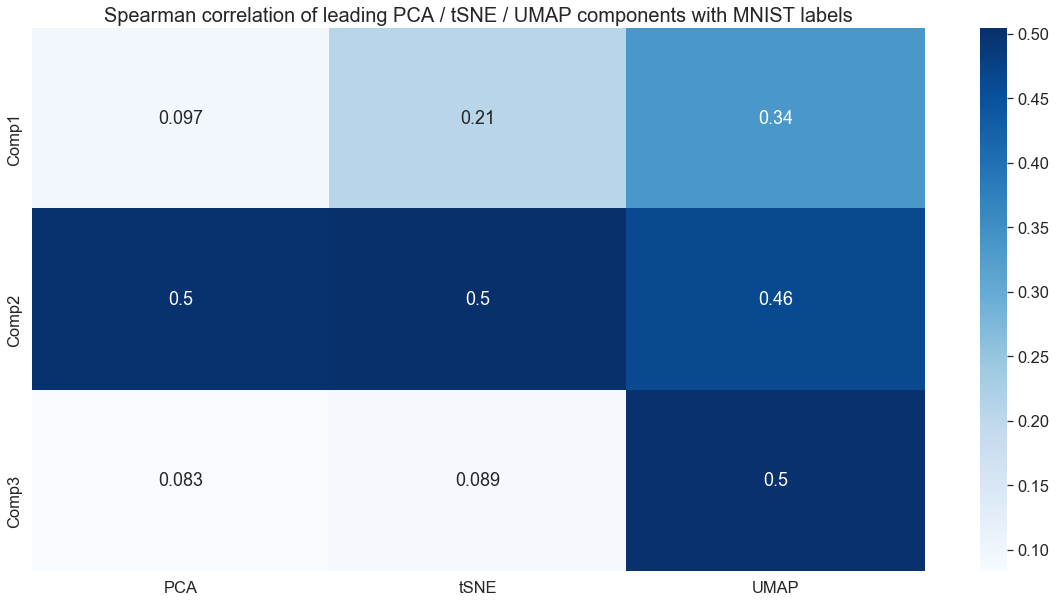

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

plt.figure(figsize = (20, 10))
sns.heatmap(rho_df.T, cmap = "Blues", annot = True)
plt.title('Spearman correlation of leading PCA / tSNE / UMAP components with MNIST labels', fontsize = 20)

plt.show()

We can observe that both tSNE1 and UMAP1 have a stronger correlation with the MNIST labels compared to PC1. Further, the second components of PCA / tSNE / UMAP have comparable strength of correlation with the MNIST labels, while the 3rd UMAP component has a much stronger correlation with MNIST labels compared to the third PCA and tSNE components, i.e. PC3 and tSNE3, respectively, which apper to be almost uncorrelated with the MNIST labels.

To confirm that the conclusion above is not a result of a particular "lucky" sample, and also to check how this conclusion is affected by the hyperparameters of tSNE and UMAP, we will introduce some **"perturbation"**. More specifically, we will use a few different sample sizes for PCA, different values of **min_dist** hyperparameter for UMAP, and different **perplexities** for tSNE. This **"perturbation"** will allow us to compute mean values and confidence intervals for the Spearman correlation coefficients.

In [163]:
import numpy as np
from scipy.stats import spearmanr
from sklearn.decomposition import PCA

N_iter = 3
N_comps = 3

N_points_list = [5000, 10000, 15000]
rho_pca_matrix = np.zeros(shape = (N_iter, N_comps))
for j in range(N_iter):
    
    X = np.log10(mnist.data + 1)
    labels = mnist.target.astype(int)
    
    np.random.seed(j + 42)
    random_indices = np.random.choice(X.shape[0], size = N_points_list[j], replace = False)
    X_sample = X[random_indices,:]
    labels_sample = labels[random_indices]
    pca_comps_sample = PCA(n_components = N_comps).fit_transform(X_sample)

    rho_pca_list = []
    for i in range(N_comps):
        
        rho_pca, pval_pca = spearmanr(pca_comps_sample[:, i], labels_sample)
        rho_pca_list.append(np.abs(rho_pca))
        
    rho_pca_matrix[j,:] = rho_pca_list

print(np.mean(rho_pca_matrix, axis = 0))

    
min_dist_list = [0.1, 0.2, 0.3]
rho_umap_matrix = np.zeros(shape = (N_iter, N_comps))
for j in range(N_iter):
    
    X = np.log10(mnist.data + 1)
    labels = mnist.target.astype(int)
    
    np.random.seed(j + 42)
    random_indices = np.random.choice(X.shape[0], size = N_points, replace = False)
    X_sample = X[random_indices,:]
    labels_sample = labels[random_indices]
    opt_perp = np.int(np.round(np.sqrt(X_sample.shape[0]), 0))
    X_reduced_sample = PCA(n_components = N_opt_pcs).fit_transform(X_sample)
    umap_embedding_sample = umap.UMAP(n_components = N_comps, n_neighbors = opt_perp, 
                                      init = X_reduced_sample[:, 0:N_comps], min_dist = min_dist_list[j], 
                                      n_epochs = 1000, verbose = 0).fit_transform(X_reduced_sample)

    rho_umap_list = []
    for i in range(N_comps):
        
        rho_umap, pval_umap = spearmanr(umap_embedding_sample[:, i], labels_sample)
        rho_umap_list.append(np.abs(rho_umap))
    
    rho_umap_matrix[j,:] = rho_umap_list
    
print(np.mean(rho_umap_matrix, axis = 0))

perp_list = [50, 100, 150]
rho_tsne_matrix = np.zeros(shape = (N_iter, N_comps))
for j in range(N_iter):
    
    X = np.log10(mnist.data + 1)
    labels = mnist.target.astype(int)
    
    np.random.seed(j + 42)
    random_indices = np.random.choice(X.shape[0], size = N_points, replace = False)
    X_sample = X[random_indices,:]
    labels_sample = labels[random_indices]
    opt_perp = np.int(np.round(np.sqrt(X_sample.shape[0]), 0))
    X_reduced_sample = PCA(n_components = N_opt_pcs).fit_transform(X_sample)
    tsne_embedding_sample = TSNE(n_components = N_comps, perplexity = perp_list[j], 
                                 init = X_reduced_sample[:, 0:N_comps], learning_rate = 200, n_iter = 1000, 
                                 verbose = 0).fit_transform(X_reduced_sample)

    rho_tsne_list = []
    for i in range(N_comps):
        
        rho_tsne, pval_tsne = spearmanr(tsne_embedding_sample[:, i], labels_sample)
        rho_tsne_list.append(np.abs(rho_tsne))
    
    rho_tsne_matrix[j,:] = rho_tsne_list
    
print(np.mean(rho_tsne_matrix, axis = 0))

[0.12054947 0.49125005 0.02803415]
[0.36196023 0.43746997 0.50201093]


In [168]:
rho_matrix = np.zeros(shape = (3, 3))

rho_matrix[0, :] = np.mean(rho_pca_matrix, axis = 0)
rho_matrix[1, :] = np.mean(rho_tsne_matrix, axis = 0)
rho_matrix[2, :] = np.mean(rho_umap_matrix, axis = 0)

rho_df = pd.DataFrame(rho_matrix, columns = ['Comp1', 'Comp2', 'Comp3'], index = ['PCA', 'tSNE', 'UMAP'])
rho_df

Comp1     Comp2     Comp3
PCA   0.120549  0.491250  0.028034
tSNE  0.239302  0.567812  0.069263
UMAP  0.361960  0.437470  0.502011

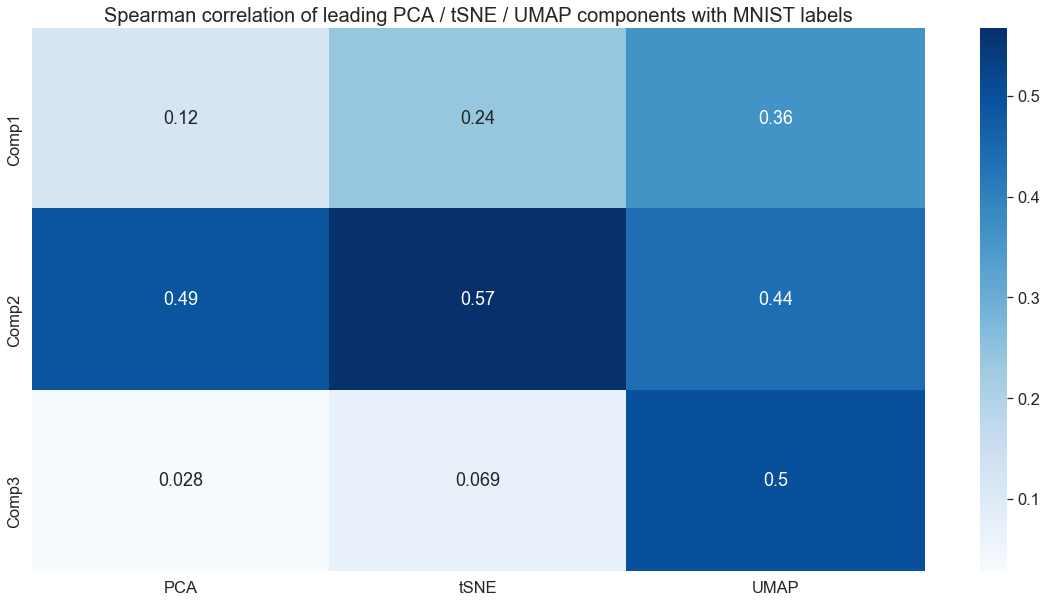

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

plt.figure(figsize = (20, 10))
sns.heatmap(rho_df.T, cmap = "Blues", annot = True)
plt.title('Spearman correlation of leading PCA / tSNE / UMAP components with MNIST labels', fontsize = 20)

plt.show()

After averaging out Spearman correlation coefficents computed for different sampling iterations and hyperparameters of tSNE and UMAP, we get a very similar Spearman correlation heatmap. Again, leading tSNE and UMAP components demonstrate consistently **greater or equal correlation** with MNIST labels compared to leading PCA components. 

We can also quantify the linkage between the PCA / tSNE / UMAP components and the MNIST labels (classes of digits, aka cell types in scRNAseq data) via the PLS regression methodology developed in the previoys sections. By analogy, if we consider **UMAP_matrix** (or **PCA_matrix** or **tSNE_matrix**) as an approximation of MNIST vector of **labels**, then we can fit the PLS model **labels = B \* UMAP_matrix**, and estimate the fraction of MNIST **labels** explained by the UMAP components as

$$\boldsymbol{\rm{labels}}=\alpha+\beta\,\, \boldsymbol{\rm{UMAP_{matrix}}}+\epsilon$$

$$\boldsymbol{R^2}=1-\frac{||\boldsymbol{\rm{labels}}-\boldsymbol{B*UMAP_{matrix}}||^2}{||\boldsymbol{\rm{labels}}||^2}$$

Let us now test how much variance in MNIST **labels** is explained by PC1, tSNE1 and UMAP1:

In [26]:
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

pca = PCA(n_components = X.shape[1]).fit(X)
pca_comps = PCA().fit_transform(X)
PCA_matrix = pd.DataFrame(pca_comps[:, 0:1])

pls = PLSRegression(n_components = 1)

pls.fit(PCA_matrix, labels)
y_pred = pls.predict(PCA_matrix)

r2_score(labels, y_pred, multioutput = 'variance_weighted')

0.01570798235844606

In [27]:
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

tSNE_matrix = pd.DataFrame(tsne_embedding[:, 0:1])
pls = PLSRegression(n_components = 1)
pls.fit(tSNE_matrix, labels)
y_pred = pls.predict(tSNE_matrix)

r2_score(labels, y_pred, multioutput = 'variance_weighted')

0.04531724676013893

In [28]:
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

UMAP_matrix = pd.DataFrame(umap_embedding[:, 0:1])
pls = PLSRegression(n_components = 1)
pls.fit(UMAP_matrix, labels)
y_pred = pls.predict(UMAP_matrix)

r2_score(labels, y_pred, multioutput = 'variance_weighted')

0.1369512765129124

We can clearly see that tSNE1 and especially UMAP1 explain much more variation in MNIST labels compared to PC1, which confirms what we previously observed with Spearman correlation, i.e. the heatmap above. We can reproduce those **R-squared** values from the linear model in **statsmodels** package.

In [29]:
my_df_comps = pd.DataFrame({'LABELS': labels, 'PC1': np.array(PCA_matrix).flatten(), 
                            'tSNE1': np.array(tSNE_matrix).flatten(), 
                            'UMAP1': np.array(UMAP_matrix).flatten()})
my_df_comps

LABELS        PC1      tSNE1     UMAP1
0          0  17.856233  21.161815  5.174302
1          9  -4.514329  -6.105692 -3.776184
2          4   2.458959   2.956050 -3.477753
3          9   0.891599 -15.131780 -3.503462
4          5   3.945029   6.770275  1.596204
...      ...        ...        ...       ...
9995       7   4.096779 -14.509716 -5.180511
9996       6  -2.173351   9.351385  1.778226
9997       5   7.062722   8.489276  1.852679
9998       9  -2.671862  -1.249276 -2.768946
9999       7  -3.018316 -10.374449 -5.741429

[10000 rows x 4 columns]

In [30]:
import statsmodels.formula.api as smf
smf.ols(formula = 'LABELS ~ PC1', data = my_df_comps).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LABELS   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     159.6
Date:                Fri, 10 Mar 2023   Prob (F-statistic):           2.68e-36
Time:                        12:25:02   Log-Likelihood:                -24751.
No. Observations:               10000   AIC:                         4.951e+04
Df Residuals:                    9998   BIC:                         4.952e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4412      0.029    154.448      0.000       4.385       4.498
PC1           -0.0565      0.004    -12.631      0.000      -0.065      -0.048
==============================================================================
Omnibus:                    37757.006   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              707.479
Skew:                           0.029   Prob(JB):                    2.36e-154
Kurtosis:                       1.698   Cond. No.                         6.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
import statsmodels.formula.api as smf
smf.ols(formula = 'LABELS ~ tSNE1', data = my_df_comps).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LABELS   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     474.6
Date:                Fri, 10 Mar 2023   Prob (F-statistic):          7.73e-103
Time:                        12:25:05   Log-Likelihood:                -24598.
No. Observations:               10000   AIC:                         4.920e+04
Df Residuals:                    9998   BIC:                         4.921e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4433      0.028    156.898      0.000       4.388       4.499
tSNE1         -0.0634      0.003    -21.785      0.000      -0.069      -0.058
==============================================================================
Omnibus:                    11710.028   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              633.768
Skew:                          -0.047   Prob(JB):                    2.39e-138
Kurtosis:                       1.770   Cond. No.                         9.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
import statsmodels.formula.api as smf
smf.ols(formula = 'LABELS ~ UMAP1', data = my_df_comps).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LABELS   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     1587.
Date:                Fri, 10 Mar 2023   Prob (F-statistic):          3.75e-322
Time:                        12:25:14   Log-Likelihood:                -24093.
No. Observations:               10000   AIC:                         4.819e+04
Df Residuals:                    9998   BIC:                         4.821e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0508      0.029    141.366      0.000       3.995       4.107
UMAP1         -0.3694      0.009    -39.831      0.000      -0.388      -0.351
==============================================================================
Omnibus:                     7395.207   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              590.775
Skew:                          -0.075   Prob(JB):                    5.19e-129
Kurtosis:                       1.819   Cond. No.                         3.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, once we have made sure that we can correctly compute the MNIST labels variance explained by PC1, tSNE1 and UMAP1 components by using the PLS and R-squared methodology, we can extend this procedure for other leading PCA, tSNE and UMAP components, and visualize how the cummulative varinace explained changes as more and more leading components are added.

In [33]:
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

predicted_var_expl_labels = []
for i in range(1, (N_comps + 1)):
    
    PCA_matrix_current_labels = pd.DataFrame(pca_comps[:, 0:i])
    pls_current_labels = PLSRegression(n_components = i)
    pls_current_labels.fit(PCA_matrix_current_labels, labels)
    y_pred_current_labels = pls_current_labels.predict(PCA_matrix_current_labels)
    predicted_var_expl_labels.append(r2_score(labels, y_pred_current_labels, multioutput = 'variance_weighted'))

    
predicted_var_expl_labels_tsne = []
for i in range(1, (N_comps + 1)):
    
    tSNE_matrix_current_labels = pd.DataFrame(tsne_embedding[:, 0:i])
    pls_current_labels_tsne = PLSRegression(n_components = i)
    pls_current_labels_tsne.fit(tSNE_matrix_current_labels, labels)
    y_pred_current_labels_tsne = pls_current_labels_tsne.predict(tSNE_matrix_current_labels)
    predicted_var_expl_labels_tsne.append(r2_score(labels, y_pred_current_labels_tsne, 
                                                   multioutput = 'variance_weighted'))    
    
predicted_var_expl_labels_umap = []
for i in range(1, (N_comps + 1)):
    
    UMAP_matrix_current_labels = pd.DataFrame(umap_embedding[:, 0:i])
    pls_current_labels_umap = PLSRegression(n_components = i)
    pls_current_labels_umap.fit(UMAP_matrix_current_labels, labels)
    y_pred_current_labels_umap = pls_current_labels_umap.predict(UMAP_matrix_current_labels)
    predicted_var_expl_labels_umap.append(r2_score(labels, y_pred_current_labels_umap, 
                                                   multioutput = 'variance_weighted'))

In [34]:
predicted_var_expl_labels

[0.01570798235844606, 0.2733383307192496, 0.27884820126125376]

In [35]:
predicted_var_expl_labels_tsne

[0.04531724676013893, 0.2889459154680104, 0.2946747041633251]

In [36]:
predicted_var_expl_labels_umap

[0.1369512765129124, 0.40283538043016953, 0.4418679565084975]

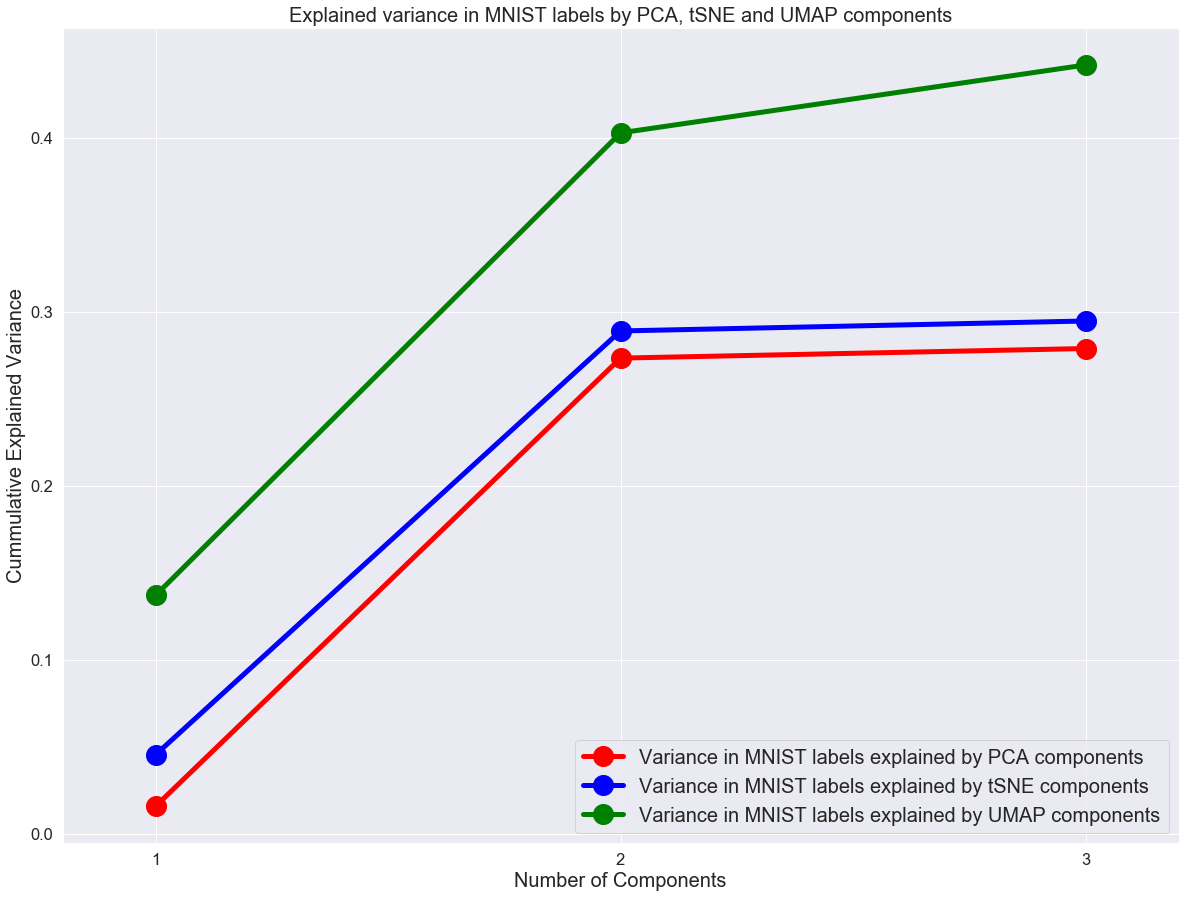

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

plt.figure(figsize = (20, 15))

#plt.plot(np.cumsum(pca.explained_variance_ratio_[0:100]), linewidth = 5)
plt.plot(range(1, (N_comps + 1)), predicted_var_expl_labels, linewidth = 5, 
         marker = 'o', markersize = 20, color = 'red')
plt.plot(range(1, (N_comps + 1)), predicted_var_expl_labels_tsne, linewidth = 5, 
         marker = 'o', markersize = 20, color = 'blue')
plt.plot(range(1, (N_comps + 1)), predicted_var_expl_labels_umap, linewidth = 5, 
         marker = 'o', markersize = 20, color = 'green')

plt.ylabel('Cummulative Explained Variance', fontsize = 20)
plt.xlabel('Number of Components', fontsize = 20)
plt.legend(['Variance in MNIST labels explained by PCA components', 
            'Variance in MNIST labels explained by tSNE components',
            'Variance in MNIST labels explained by UMAP components'], fontsize = 20)
plt.title('Explained variance in MNIST labels by PCA, tSNE and UMAP components', fontsize = 20)
plt.xlim([0.8, (N_comps + 0.2)])
plt.xticks([1, 2, 3])

plt.show()

Here, surprisingly, we observe that leading UMAP and tSNE components seem to explain more of variation in the MNIST **labels** compared to leading PCA components, although in the previous section we saw that leading tSNE and UMAP components explain less variation in MNIST image pixel intensity data set. Anyway, this explained variance plot above basically confirms the correlation heatmap obtained previously. Similarly to the correlation heatmap, let us now build confidence intervals by introducing a perturbation on sample size and hyperparameters of tSNE and UMAP.

In [102]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

N_iter = 3
N_comps = 3

N_points_list = [5000, 10000, 15000]
predicted_var_expl_labels_matrix = np.zeros(shape = (N_iter, N_comps))
for j in range(N_iter):
    
    X = np.log10(mnist.data + 1)
    labels = mnist.target.astype(int)
    
    np.random.seed(j)
    random_indices = np.random.choice(X.shape[0], size = N_points_list[j], replace = False)
    X_sample = X[random_indices,:]
    labels_sample = labels[random_indices]

    pca_comps_sample = PCA(n_components = N_comps).fit_transform(X_sample)

    predicted_var_expl_labels = []
    for i in range(1, (N_comps + 1)):
    
        PCA_matrix_current_labels = pd.DataFrame(pca_comps_sample[:, 0:i])
        pls_current_labels = PLSRegression(n_components = i)
        pls_current_labels.fit(PCA_matrix_current_labels, labels_sample)
        y_pred_current_labels = pls_current_labels.predict(PCA_matrix_current_labels)
        predicted_var_expl_labels.append(r2_score(labels_sample, y_pred_current_labels, 
                                                  multioutput = 'variance_weighted'))
    
    predicted_var_expl_labels_matrix[j,:] = predicted_var_expl_labels
    
print(predicted_var_expl_labels_matrix)

[[0.03418984 0.27663261 0.29223446]
 [0.0265549  0.28409257 0.28739842]
 [0.03096174 0.27898829 0.2794116 ]]


In [94]:
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

N_iter = 3
N_comps = 3

min_dist_list = [0.1, 0.2, 0.3]
predicted_var_expl_labels_umap_matrix = np.zeros(shape = (N_iter, N_comps))
for j in range(N_iter):
    
    X = np.log10(mnist.data + 1)
    labels = mnist.target.astype(int)
    
    np.random.seed(j)
    random_indices = np.random.choice(X.shape[0], size = N_points, replace = False)
    X_sample = X[random_indices,:]
    labels_sample = labels[random_indices]

    opt_perp = np.int(np.round(np.sqrt(X_sample.shape[0]), 0))
    X_reduced_sample = PCA(n_components = N_opt_pcs).fit_transform(X_sample)
    umap_embedding_sample = umap.UMAP(n_components = N_comps, n_neighbors = opt_perp, 
                                      init = X_reduced_sample[:, 0:N_comps], min_dist = min_dist_list[j], 
                                      n_epochs = 1000, verbose = 0).fit_transform(X_reduced_sample)
    
    
    predicted_var_expl_labels_umap = []
    for i in range(1, (N_comps + 1)):
    
        UMAP_matrix_current_labels = pd.DataFrame(umap_embedding_sample[:, 0:i])
        pls_current_labels_umap = PLSRegression(n_components = i)
        pls_current_labels_umap.fit(UMAP_matrix_current_labels, labels_sample)
        y_pred_current_labels_umap = pls_current_labels_umap.predict(UMAP_matrix_current_labels)
        predicted_var_expl_labels_umap.append(r2_score(labels_sample, y_pred_current_labels_umap, 
                                                       multioutput = 'variance_weighted'))
        
    predicted_var_expl_labels_umap_matrix[j,:] = predicted_var_expl_labels_umap
    
print(predicted_var_expl_labels_umap_matrix)

[[0.11387707 0.4402719  0.44062214]
 [0.17474769 0.42399884 0.46337209]
 [0.19358502 0.46151567 0.46439848]]


In [95]:
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

N_iter = 3
N_comps = 3

perp_list = [90, 100, 110]
predicted_var_expl_labels_tsne_matrix = np.zeros(shape = (N_iter, N_comps))
for j in range(N_iter):
    
    X = np.log10(mnist.data + 1)
    labels = mnist.target.astype(int)
    
    np.random.seed(j)
    random_indices = np.random.choice(X.shape[0], size = N_points, replace = False)
    X_sample = X[random_indices,:]
    labels_sample = labels[random_indices]

    opt_perp = np.int(np.round(np.sqrt(X_sample.shape[0]), 0))
    X_reduced_sample = PCA(n_components = N_opt_pcs).fit_transform(X_sample)
    tsne_embedding_sample = TSNE(n_components = N_comps, perplexity = perp_list[j], 
                                 init = X_reduced_sample[:, 0:N_comps], learning_rate = 200, n_iter = 1000, 
                                 verbose = 0).fit_transform(X_reduced_sample)
    
    
    predicted_var_expl_labels_tsne = []
    for i in range(1, (N_comps + 1)):
    
        tSNE_matrix_current_labels = pd.DataFrame(tsne_embedding_sample[:, 0:i])
        pls_current_labels_tsne = PLSRegression(n_components = i)
        pls_current_labels_tsne.fit(tSNE_matrix_current_labels, labels_sample)
        y_pred_current_labels_tsne = pls_current_labels_tsne.predict(tSNE_matrix_current_labels)
        predicted_var_expl_labels_tsne.append(r2_score(labels_sample, y_pred_current_labels_tsne, 
                                                       multioutput = 'variance_weighted'))
        
    predicted_var_expl_labels_tsne_matrix[j,:] = predicted_var_expl_labels_tsne
    
print(predicted_var_expl_labels_tsne_matrix)

[[0.05256715 0.42521766 0.42522009]
 [0.04544361 0.43253247 0.43270026]
 [0.06398196 0.42287358 0.42328422]]


Finally, let us visualize the cummulative variance explained by leading PCA, tSNE and UMAP components.

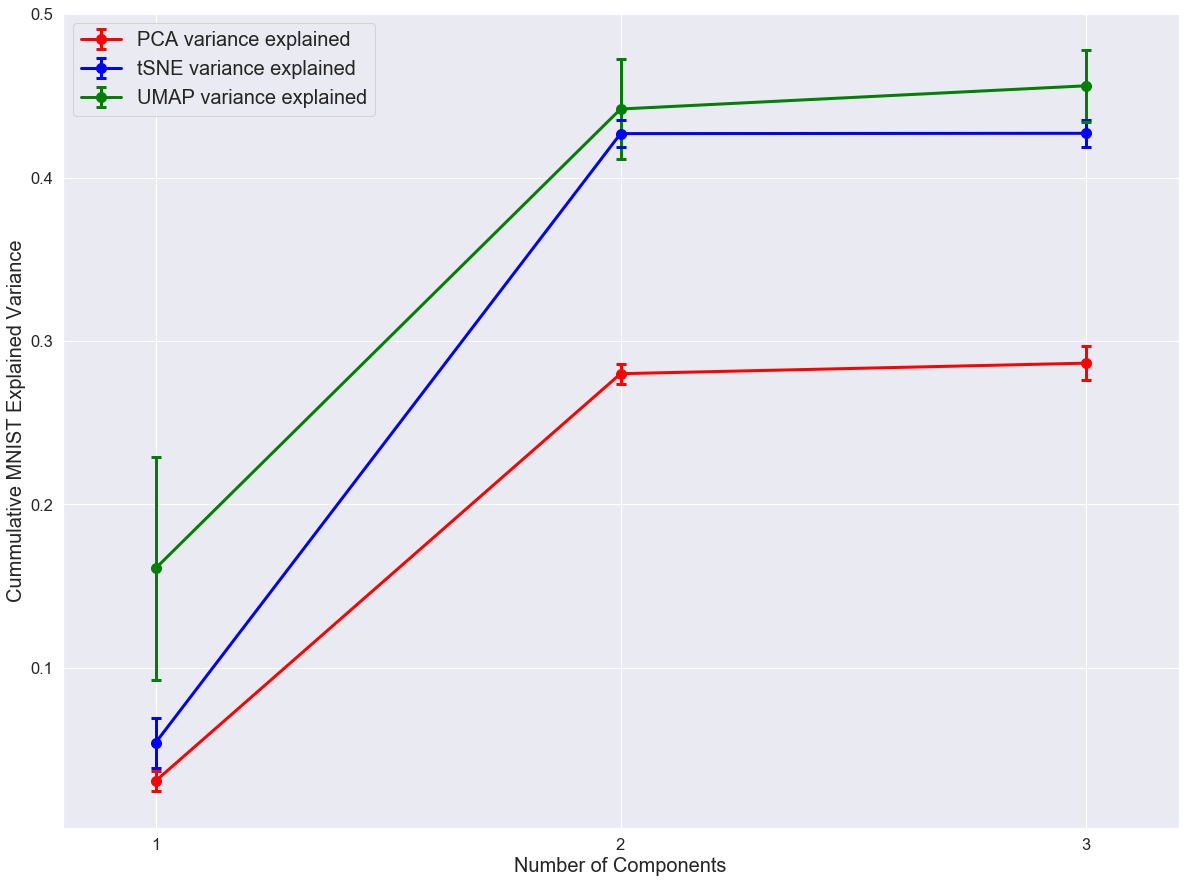

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

plt.figure(figsize = (20, 15))

plt.errorbar(range(1, (N_comps + 1)), np.mean(predicted_var_expl_labels_matrix, axis = 0), 
             yerr = 2*np.std(predicted_var_expl_labels_matrix, axis = 0), linewidth = 3, color = 'red', 
             marker = 'o', markersize = 10, capsize = 5, capthick = 3)
plt.errorbar(range(1, (N_comps + 1)), np.mean(predicted_var_expl_labels_tsne_matrix, axis = 0), 
             yerr = 2*np.std(predicted_var_expl_labels_tsne_matrix, axis = 0), linewidth = 3, color = 'blue', 
             marker = 'o', markersize = 10, capsize = 5, capthick = 3)
plt.errorbar(range(1, (N_comps + 1)), np.mean(predicted_var_expl_labels_umap_matrix, axis = 0), 
             yerr = 2*np.std(predicted_var_expl_labels_umap_matrix, axis = 0), linewidth = 3, color = 'green', 
             marker = 'o', markersize = 10, capsize = 5, capthick = 3)

plt.ylabel('Cummulative MNIST Explained Variance', fontsize = 20)
plt.xlabel('Number of Components', fontsize = 20)
plt.legend(['PCA variance explained', 'tSNE variance explained', 'UMAP variance explained'], fontsize = 20)
plt.xlim([0.8, (N_comps + 0.2)])
plt.xticks([1, 2, 3])

plt.show()

Here we have an interesting effect. We saw in the previous section that the leading tSNE and UMAP components can not capture more variation in MNIST than leading PCA components. However, surpisingly, they are **capable of capturing more variation in MNIST labels, i.e. classes of hand-written digits**, despite the classes were not provided to tSNE / UMAP when performing dimension reduction. In other words, all three dimension reduction techniques are completely unsupervised, i.e. they know nothing about the classes of digits. Nevertheless, tSNE and especially UMAP components seem to be surprisingly linked to the classes of digits without being able to capture substantial proportion of variation in MNIST pixel intensities across the images.